In [3]:
text = """Cell biology is the study of cell structure and function, and it revolves around the concept that the cell is the fundamental unit of life. Focusing on the cell permits a detailed understanding of the tissues and organisms that cells compose. Some organisms have only one cell, while others are organized into cooperative groups with huge numbers of cells. On the whole, cell biology focuses on the structure and function of a cell, from the most general properties shared by all cells, to the unique, highly intricate functions particular to specialized cells.

The starting point for this discipline might be considered the 1830s. Though scientists had been using microscopes for centuries, they were not always sure what they were looking at. Robert Hooke's initial observation in 1665 of plant-cell walls in slices of cork was followed shortly by Antonie van Leeuwenhoek's first descriptions of live cells with visibly moving parts. In the 1830s two scientists who were colleagues — Schleiden, looking at plant cells, and Schwann, looking first at animal cells — provided the first clearly stated definition of the cell. Their definition stated that that all living creatures, both simple and complex, are made out of one or more cells, and the cell is the structural and functional unit of life — a concept that became known as cell theory.

As microscopes and staining techniques improved over the nineteenth and twentieth centuries, scientists were able to see more and more internal detail within cells. The microscopes used by van Leeuwenhoek probably magnified specimens a few hundredfold. Today high-powered electron microscopes can magnify specimens more than a million times and can reveal the shapes of organelles at the scale of a micrometer and below. With confocal microscopy a series of images can be combined, allowing researchers to generate detailed three-dimensional representations of cells. These improved imaging techniques have helped us better understand the wonderful complexity of cells and the structures they form.

There are several main subfields within cell biology. One is the study of cell energy and the biochemical mechanisms that support cell metabolism. As cells are machines unto themselves, the focus on cell energy overlaps with the pursuit of questions of how energy first arose in original primordial cells, billions of years ago. Another subfield of cell biology concerns the genetics of the cell and its tight interconnection with the proteins controlling the release of genetic information from the nucleus to the cell cytoplasm. Yet another subfield focuses on the structure of cell components, known as subcellular compartments. Cutting across many biological disciplines is the additional subfield of cell biology, concerned with cell communication and signaling, concentrating on the messages that cells give to and receive from other cells and themselves. And finally, there is the subfield primarily concerned with the cell cycle, the rotation of phases beginning and ending with cell division and focused on different periods of growth and DNA replication. Many cell biologists dwell at the intersection of two or more of these subfields as our ability to analyze cells in more complex ways expands.

In line with continually increasing interdisciplinary study, the recent emergence of systems biology has affected many biological disciplines; it is a methodology that encourages the analysis of living systems within the context of other systems. In the field of cell biology, systems biology has enabled the asking and answering of more complex questions, such as the interrelationships of gene regulatory networks, evolutionary relationships between genomes, and the interactions between intracellular signaling networks. Ultimately, the broader a lens we take on our discoveries in cell biology, the more likely we can decipher the complexities of all living systems, large and small.
"""

In [4]:
reference_summary = """Cell biology is the study of cell structure and function, focusing on the cell as the fundamental unit of life. It involves understanding how cells form tissues and organisms. Some organisms consist of one cell, while others have cooperative groups of many cells. The field examines the general properties shared by all cells and the unique functions of specialized cells.

Cell biology's origins trace back to the 1830s, with early observations by Robert Hooke and Antonie van Leeuwenhoek. In the 1830s, Schleiden and Schwann defined the cell, establishing the foundation of cell theory, which states that all living creatures are made of cells, and the cell is the unit of life.

Advancements in microscopy and staining techniques, from Hooke's early microscope to today's electron microscopes, have allowed scientists to study cells in greater detail. With these technologies, we can now observe organelles and generate three-dimensional representations of cells.

Key subfields within cell biology include cell energy and metabolism, genetics and protein regulation, subcellular compartments, cell communication, and the cell cycle. Additionally, systems biology, which emerged recently, has allowed scientists to explore complex questions about gene networks, genomes, and intracellular signaling.

By expanding our understanding through interdisciplinary approaches, cell biology helps decipher the complexities of living systems."""

In [1]:
!pip install spacy

In [13]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
from collections import Counter
import re

In [14]:
nlp = spacy.load("en_core_web_sm")


def summarize_text(text, compression_ratio=0.3):
    try:
        doc = nlp(text)
        stopwords = list(STOP_WORDS)
        word_frequencies = {}

        # word frequencies
        for word in doc:
            if word.text.lower() not in stopwords and word.text.lower() not in punctuation:
                word_frequencies[word.text.lower()] = word_frequencies.get(word.text.lower(), 0) + 1

        max_frequency = max(word_frequencies.values(), default=1)
        word_frequencies = {word: freq / max_frequency for word, freq in word_frequencies.items()}

        # scoring
        sentence_scores = {}
        for sentence in doc.sents:
            for word in sentence:
                if word.text.lower() in word_frequencies:
                    sentence_scores[sentence] = sentence_scores.get(sentence, 0) + word_frequencies[word.text.lower()]

        # top sentences
        select_length = int(len(list(doc.sents)) * compression_ratio)
        summarized_sentences = nlargest(select_length, sentence_scores, key=sentence_scores.get)
        summary = ' '.join([sentence.text for sentence in summarized_sentences])
        return summary
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return text

def rouge_n(reference, summary, n=1):
    reference_tokens = re.findall(r'\w+', reference.lower())
    summary_tokens = re.findall(r'\w+', summary.lower())

    reference_ngrams = Counter([tuple(reference_tokens[i:i + n]) for i in range(len(reference_tokens) - n + 1)])
    summary_ngrams = Counter([tuple(summary_tokens[i:i + n]) for i in range(len(summary_tokens) - n + 1)])

    common_ngrams = reference_ngrams & summary_ngrams
    common_count = sum(common_ngrams.values())

    precision = common_count / (len(summary_ngrams) + 1e-9)
    recall = common_count / (len(reference_ngrams) + 1e-9)
    f1 = (2 * precision * recall) / (precision + recall + 1e-9)

    return precision, recall, f1

def rouge_l(reference, summary):
    reference_tokens = reference.split()
    summary_tokens = summary.split()

    lcs_length = lcs(reference_tokens, summary_tokens)

    precision = lcs_length / len(summary_tokens) if summary_tokens else 0
    recall = lcs_length / len(reference_tokens) if reference_tokens else 0
    f1 = (2 * precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero

    return precision, recall, f1

def lcs(ref, hyp):
    m, n = len(ref), len(hyp)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    return dp[m][n]


generated_summary = summarize_text(text, compression_ratio=0.3)

precision, recall, f1 = rouge_n(reference_summary, generated_summary, n=1)
print(f"ROUGE-1 Precision (Unigrams): {precision}, Recall: {recall}, F1: {f1}")

precision, recall, f1 = rouge_n(reference_summary, generated_summary, n=2)
print(f"ROUGE-2 Precision (Bigrams): {precision}, Recall: {recall}, F1: {f1}")

precision, recall, f1 = rouge_l(reference_summary, generated_summary)
print(f"ROUGE-L Precision: {precision}, Recall: {recall}, F1: {f1}")



ROUGE-1 Precision (Unigrams): 0.9396551724056926, Recall: 0.8449612403035275, F1: 0.889795917861491
ROUGE-2 Precision (Bigrams): 0.2604166666653103, Recall: 0.2604166666653103, F1: 0.26041666616531034
ROUGE-L Precision: 0.21524663677130046, Recall: 0.23300970873786409, F1: 0.2237762232770089


In [11]:
print(generated_summary)

On the whole, cell biology focuses on the structure and function of a cell, from the most general properties shared by all cells, to the unique, highly intricate functions particular to specialized cells.

 Cutting across many biological disciplines is the additional subfield of cell biology, concerned with cell communication and signaling, concentrating on the messages that cells give to and receive from other cells and themselves. Cell biology is the study of cell structure and function, and it revolves around the concept that the cell is the fundamental unit of life. Another subfield of cell biology concerns the genetics of the cell and its tight interconnection with the proteins controlling the release of genetic information from the nucleus to the cell cytoplasm. Their definition stated that that all living creatures, both simple and complex, are made out of one or more cells, and the cell is the structural and functional unit of life — a concept that became known as cell theory.


In [12]:
print(reference_summary)

Cell biology is the study of cell structure and function, focusing on the cell as the fundamental unit of life. It involves understanding how cells form tissues and organisms. Some organisms consist of one cell, while others have cooperative groups of many cells. The field examines the general properties shared by all cells and the unique functions of specialized cells.

Cell biology's origins trace back to the 1830s, with early observations by Robert Hooke and Antonie van Leeuwenhoek. In the 1830s, Schleiden and Schwann defined the cell, establishing the foundation of cell theory, which states that all living creatures are made of cells, and the cell is the unit of life.

Advancements in microscopy and staining techniques, from Hooke's early microscope to today's electron microscopes, have allowed scientists to study cells in greater detail. With these technologies, we can now observe organelles and generate three-dimensional representations of cells.

Key subfields within cell biolog

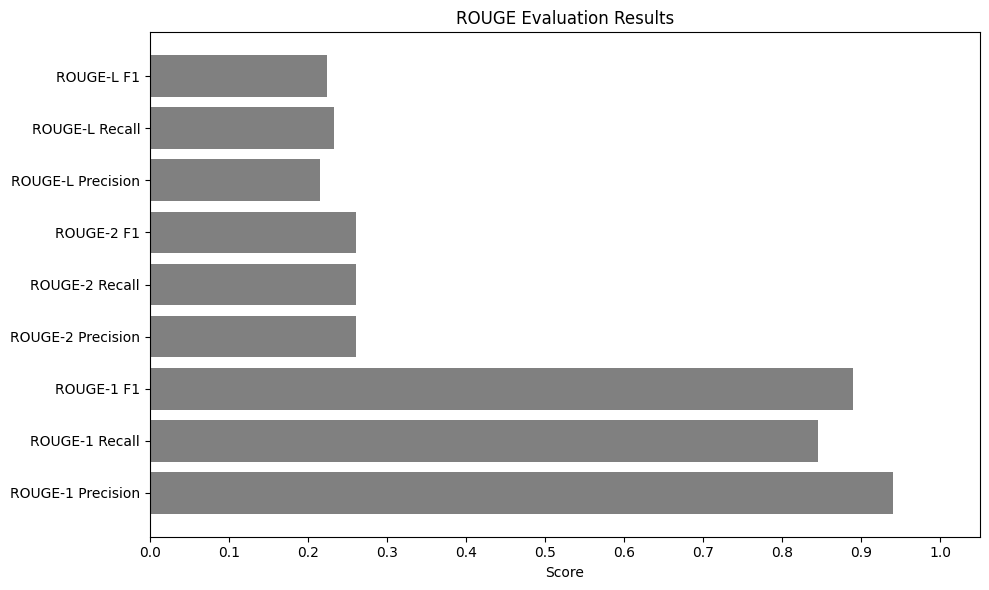

In [23]:
import matplotlib.pyplot as plt

# ROUGE
rouge_metrics = ['ROUGE-1 Precision', 'ROUGE-1 Recall', 'ROUGE-1 F1',
                 'ROUGE-2 Precision', 'ROUGE-2 Recall', 'ROUGE-2 F1',
                 'ROUGE-L Precision', 'ROUGE-L Recall', 'ROUGE-L F1']

scores = [0.9397, 0.8450, 0.8898,  # ROUGE-1
          0.2604, 0.2604, 0.2604,  # ROUGE-2
          0.2152, 0.2330, 0.2238]  # ROUGE-L

plt.figure(figsize=(10, 6))
plt.barh(rouge_metrics, scores, color=['#808080'])

plt.xlabel('Score')
plt.title('ROUGE Evaluation Results')
plt.xlim(0, 1.05)
plt.xticks([i / 10 for i in range(11)])

plt.tight_layout()
plt.show()
